In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rich import print
from sklearn.metrics import mean_pinball_loss, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("energy_no_outliers_drop_.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,ref_datetime,valid_datetime,SolarDownwardRadiation,Temperature,CloudCover,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,Wind_MWh_credit,Solar_MWh_credit
0,0,0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.0,13.646173,0.450405,2020-09-20 00:00:00+00:00,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17,498.142,0.0
1,1,1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,0.0,13.658508,0.472211,2020-09-20 00:30:00+00:00,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17,478.788,0.0
2,2,2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.0,13.670843,0.494018,2020-09-20 01:00:00+00:00,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,470.522,0.0
3,3,3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,0.0,13.732101,0.520214,2020-09-20 01:30:00+00:00,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00,482.183,0.0
4,4,4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.0,13.793360,0.546410,2020-09-20 02:00:00+00:00,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,459.216,0.0


In [3]:
# Load the dataset
df = pd.read_csv('energy_no_outliers_drop_.csv')

# Convert datetime columns to datetime type
df['dtm'] = pd.to_datetime(df['dtm'])
df['ref_datetime'] = pd.to_datetime(df['ref_datetime'])
df['valid_datetime'] = pd.to_datetime(df['valid_datetime'])

# Check for non-numeric values in the DataFrame
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)
df.drop(columns=['ref_datetime', 'valid_datetime'], inplace=True)

# Extract useful components
df['year'] = df['dtm'].dt.year
df['month'] = df['dtm'].dt.month
df['day'] = df['dtm'].dt.day
df['hour'] = df['dtm'].dt.hour
df['minute'] = df['dtm'].dt.minute

# # Convert time of day to minutes past midnight
df['time_minutes'] = df['hour'] * 60 + df['minute']

# # Drop original 'dtm' column and other intermediate columns
df.drop(columns=['dtm', 'hour', 'minute', 'Wind_MW', 'SS_Price', 'DA_Price', 'Wind_MWh_credit', 'MIP', 'Solar_MWh_credit', 'Solar_installedcapacity_mwp', 'boa_MWh', 'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

data = df.copy()
# Check the modified dataframe
print(df.head())
df.shape

Non-numeric columns: Index(['ref_datetime', 'valid_datetime', 'dtm'], dtype='object')

SolarDownwardRadiation  Temperature  CloudCover  Solar_MW  \
0                     0.0    13.646173    0.450405       0.0   
1                     0.0    13.658508    0.472211       0.0   
2                     0.0    13.670843    0.494018       0.0   
3                     0.0    13.732101    0.520214       0.0   
4                     0.0    13.793360    0.546410       0.0   

   Solar_capacity_mwp  year  month  day  time_minutes  
0         2108.489754  2020      9   20             0  
1         2108.489754  2020      9   20            30  
2         2108.489754  2020      9   20            60  
3         2108.489754  2020      9   20            90  
4         2108.489754  2020      9   20           120

(279662, 9)

# Model Prediction

### For this problem, we need to predict the solar power production. We chose three models of machine learning that have different advantages:

GradientBoostingRegressor (GBR):

Robustness and precision: The GBR model builds several decision trees in series, where each tree corrects the errors of the previous tree. This creates a very precise model that can capture complex relationships between variables.
Over-Learning Resistance: Through the boosting approach, GBR can avoid over-learning by gradually adjusting the model.
Computation time: 45 seconds
Pinball Loss: ~3.6

RandomForestRegressor (RFR):

Stability and generalization: The RFR model builds several decision trees in parallel and uses the mean of the predictions. This improves stability and reduces the risk of overlearning.
Importance of variables: RFR also allows to assess the importance of variables, helping to identify the most influential factors on solar energy production.
Management of missing values and outliers: RFR is robust to missing values and outliers, making it suitable for real data often imperfect.
Computation time: 2 minutes and 30 seconds
Pinball Loss: ~1.3

LinearRegression (LR):

Simplicity and speed: LR is a simple and quick-to-drive model, providing a basis for comparison for more complex models.
Interpretability: LR provides direct coefficients that can be easily interpreted, making it possible to understand the influence of each variable on solar energy production.
Performance on linear data: If the relationships between input variables and energy production are linear or almost linear, LR can give good performance.
Computation time: 0.1 seconds
Pinball Loss: ~7

Analyse of the Models:

RandomForestRegressor has the lowest Pinball Loss for median (1.3686), low (1.3545), and high (1.3826) production. This indicates that this model provides the most accurate predictions among the three models tested.
GradientBoostingRegressor has intermediate Pinball Loss values (3.6853, 3.6922, 3.6784), which are less precise than those of the RandomForestRegressor but significantly better than those of the LinearRegression.
LinearRegression has the highest Pinball Loss values (7.0576, 7.0269, 7.0883), indicating that its predictions are the least accurate.

RandomForestRegressor is the best choice in terms of accuracy despite its longer computation time.
GradientBoostingRegressor offers a good balance between accuracy and computation time.
LinearRegression is not recommended, it does not make accurate predictions.

## GradientBoosting

#### Première prédiction

##### Toutes les features sont présentes, seulement les colonnes "target" sont retirées.

In [4]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

scaler = StandardScaler()

# Fit the scaler on the feature data
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X_scaled, y_solar, test_size=0.2, random_state=42)

# Train separate gradient boosting models for Solar and Wind
solar_model = GradientBoostingRegressor(random_state=42)
solar_model.fit(X_train, y_solar_train)

# Make predictions
y_solar_pred = solar_model.predict(X_test)

pinball_loss_solar1 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.5)
print("Pinball Loss for Median Solar Power Production:", pinball_loss_solar1)
pinball_loss_solar2 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.05)
print("Pinball Loss for Low Solar Power Production:", pinball_loss_solar2)
pinball_loss_solar3 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.95)
print("Pinball Loss for High Solar Power Production:", pinball_loss_solar3)

# Evaluate the model using additional metrics
mse = mean_squared_error(y_solar_test, y_solar_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_solar_test, y_solar_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Pinball Loss for Median Solar Power Production: 3.6654878670990163

Pinball Loss for Low Solar Power Production: 3.6671645396783226

Pinball Loss for High Solar Power Production: 3.6638111945197105

Mean Squared Error (MSE): 312.4730886387019

Root Mean Squared Error (RMSE): 17.67690834503313

Mean Absolute Error (MAE): 7.330975734198033

##### Importance of the features :

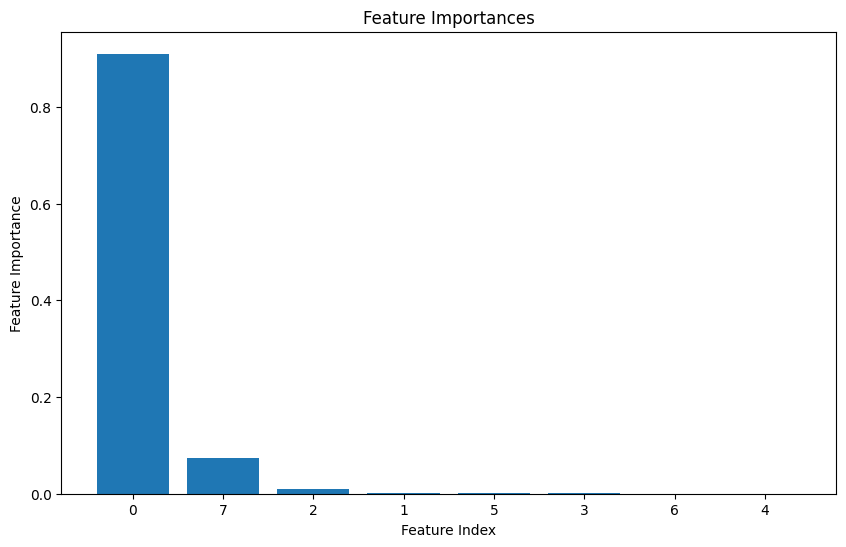

In [5]:

# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

scaler = StandardScaler()

# Fit the scaler on the feature data
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X_scaled, y_solar, test_size=0.2, random_state=42)

# Initialize Gradient Boosting model
gbm_model = GradientBoostingRegressor()

# Fit the model
gbm_model.fit(X_train, y_solar_train)

# Get feature importances
importances = gbm_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.show()

In [6]:
# # Define features and target variables
# X = df.drop(columns=['Solar_MW'])  # Features
# y_solar = df['Solar_MW']  # Solar target variable

# scaler = StandardScaler()

# # Fit the scaler on the feature data
# X_scaled = scaler.fit_transform(X)

# # Split the data into training and testing sets
# X_train, X_test, y_solar_train, y_solar_test = train_test_split(
#     X_scaled, y_solar, test_size=0.2, random_state=42)

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200],  # Number of boosting stages
#     'learning_rate': [0.01, 0.1],  # Learning rate (shrinkage)
#     'max_depth': [3, 5],  # Maximum depth of the individual regression estimators
# }

# # Initialize GBM model
# gbm_model = GradientBoostingRegressor(random_state=42)

# # Initialize GridSearchCV with 5-fold cross-validation
# grid_search = GridSearchCV(gbm_model, param_grid, cv=3, scoring='neg_mean_squared_error')

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_solar_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters for Solar Power Production:", best_params)

### RandomForestRegressor

In [ ]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_solar_train)

# Make predictions
y_solar_pred = model.predict(X_test)

# Evaluate the model
pinball_loss_solar1 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.5)
print("Pinball Loss for Median Solar Power Production:", pinball_loss_solar1)
pinball_loss_solar2 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.05)
print("Pinball Loss for Low Solar Power Production:", pinball_loss_solar2)
pinball_loss_solar3 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.95)
print("Pinball Loss for High Solar Power Production:", pinball_loss_solar3)

# Evaluate the model using additional metrics
mse = mean_squared_error(y_solar_test, y_solar_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_solar_test, y_solar_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)



Pinball Loss for Median Solar Power Production: 1.3685667610234005

Pinball Loss for Low Solar Power Production: 1.3545448130445943

Pinball Loss for High Solar Power Production: 1.3825887090022069

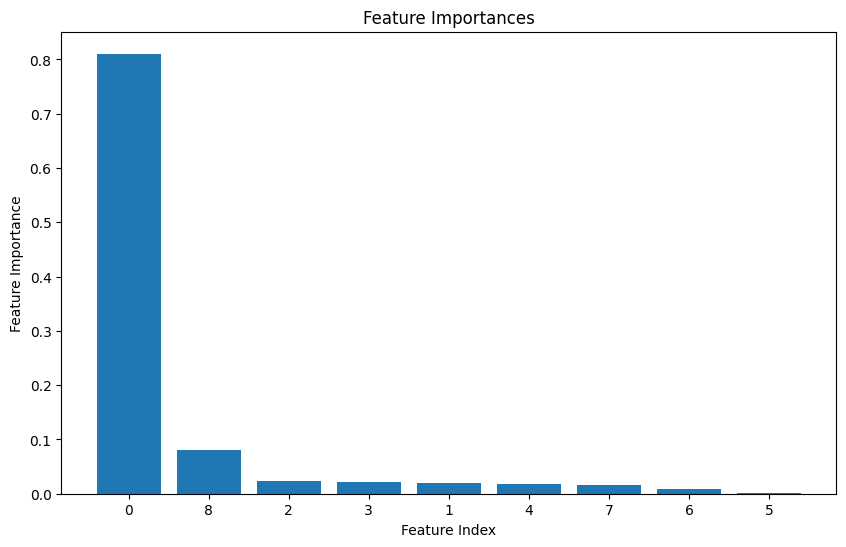

In [ ]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Initialize Gradient Boosting model
rfr_model = RandomForestRegressor()

# Fit the model
rfr_model.fit(X_train, y_solar_train)

# Get feature importances
importances = rfr_model.feature_importances_



# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.show()

## Linear Regression

In [ ]:
# Define features and target variables
X = df.drop(columns=['Solar_MW'])  # Features
y_solar = df['Solar_MW']  # Solar target variable

# Split the data into training and testing sets
X_train, X_test, y_solar_train, y_solar_test = train_test_split(
    X, y_solar, test_size=0.2, random_state=42)

# Train separate linear regression models for Solar and Wind
solar_model = LinearRegression()
solar_model.fit(X_train, y_solar_train)

# Make predictions
y_solar_pred = solar_model.predict(X_test)

# Combine predictions

# Evaluate the combined prediction using Pinball Loss
pinball_loss_total1 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.5)
print("Pinball Loss for Median Solar Power Production:", pinball_loss_total1)
pinball_loss_total2 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.05)
print("Pinball Loss for Low Solar Power Production:", pinball_loss_total2)
pinball_loss_total3 = mean_pinball_loss(y_solar_pred, y_solar_test, alpha=0.95)
print("Pinball Loss for High Solar Power Production:", pinball_loss_total3)

# Evaluate the model using additional metrics
mse = mean_squared_error(y_solar_test, y_solar_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_solar_test, y_solar_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Pinball Loss for Median Solar Power Production: 7.057567704182342

Pinball Loss for Low Solar Power Production: 7.0268728358983825

Pinball Loss for High Solar Power Production: 7.088262572466303